In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from wordcloud import WordCloud, STOPWORDS

import re
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
lemma = WordNetLemmatizer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/popolilvlad1122/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/popolilvlad1122/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("df_text_eng.csv")

In [3]:
df['state'] = df['state'].map({"failed": 0, "successful": 1})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215513 entries, 0 to 215512
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  215513 non-null  int64 
 1   blurb       215510 non-null  object
 2   state       215513 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.9+ MB


In [5]:
df.isnull().sum()

Unnamed: 0    0
blurb         3
state         0
dtype: int64

In [6]:
#Предполагаю, что NaN в blurb означает что автор, не потрудился написать
#описание своего проекта.
#Значит залью эти значение пустой строкой
df[df.isnull().any(axis=1)]

,Unnamed: 0,blurb,state
44343,44344,NaN,0
62766,62767,NaN,0
97999,98000,NaN,0


In [7]:
df.fillna('', inplace=True)
df.isnull().sum()

Unnamed: 0    0
blurb         0
state         0
dtype: int64

## Исследование и визуализация данных

1.0

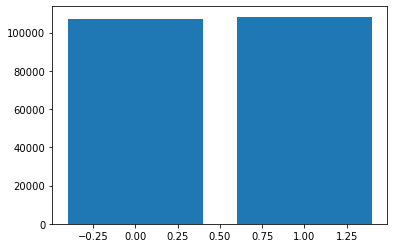

In [8]:
#Фактически распределение равномерно. Но следует это проверить
F, p = st.chisquare(df['state'])
state_r = df.groupby('state')['state'].count()
plt.bar(state_r.index, state_r)
p

Длина 1:  115.33886991044226 Длина 0:  114.4620952771844


<BarContainer object of 2 artists>

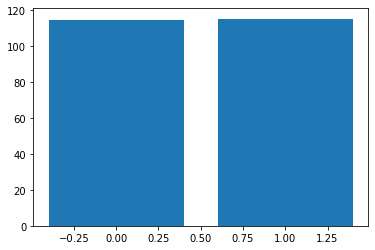

In [9]:
#Средний размер описания по классам
from statistics import mean
describe_1 = df[df['state'] == 1]['blurb']
describe_0 = df[df['state'] == 0]['blurb']

max_len_1 = 0
for text in describe_1:
    if len(text) > max_len_1:
        max_len_1 = len(text)
    
len_0 = []
for text in describe_0:
    len_0.append(len(text))
mean_0 = mean(len_0)

len_1 = []
for text in describe_1:
    len_1.append(len(text))
mean_1 = mean(len_1)
        
print("Длина 1: ", mean_1, "Длина 0: ", mean_0)
plt.bar([1, 0], [mean_1, mean_0])

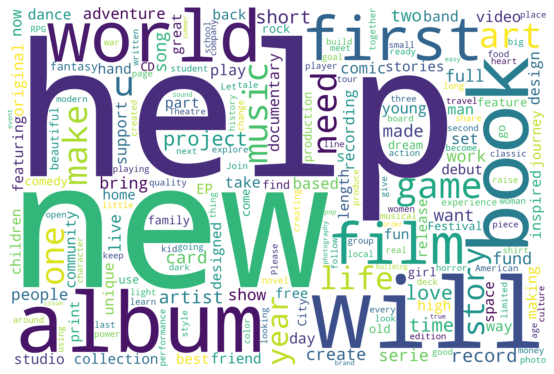

In [10]:
all_headlines = ' '.join(describe_1)
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                      collocations = False).generate((all_headlines))
plt.figure(figsize = (15, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

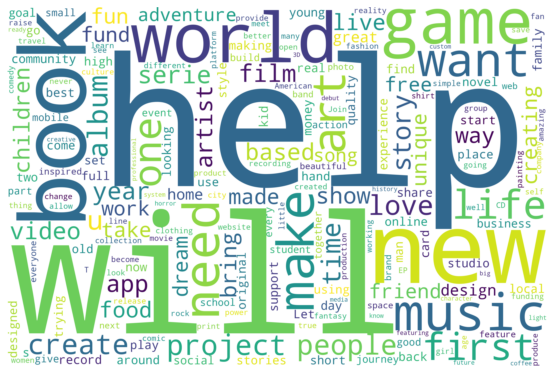

In [11]:
all_headlines = ' '.join(describe_0)
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                      collocations = False).generate((all_headlines))
plt.figure(figsize = (15, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Понятно, что зависимость в различиях больше семантическая

## Vectorization data

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words = set(stop_words)

In [13]:
def clean(text):
    text = re.sub('\s+', ' ', text)
    text = re.sub("\'", "", text)
    return text


def doc_to_words(doc, stop_words, lemma):
    stop_words = set(stop_words)
    words = [w for w in gensim.utils.simple_preprocess(str(doc), deacc=True) if w not in stop_words]
    words = [lemma.lemmatize(w) for w in words]
    
    return words

In [14]:
# Convert to list
data = df.blurb.values.tolist()

data = [clean(t) for t in data]
data_words = [doc_to_words(t, stop_words, lemma) for t in data]
    
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigram_mod.save('bigram_mod.pkl')
data_words_bigrams = [bigram_mod[w] for w in data_words]

In [15]:
data_words_bigrams[0][:10]

['using',
 'character',
 'user',
 'go',
 'educational',
 'quest',
 'around',
 'virtual',
 'world',
 'leveling']

In [16]:
id2word = corpora.Dictionary(data_words_bigrams)
id2word.save('id2word.pkl')
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [17]:
id2word[8]

'quest'

In [18]:
data[0]

'Using their own character, users go on educational quests around a virtual world leveling up subject-oriented skills (ie Physics).'

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=25, step=5)

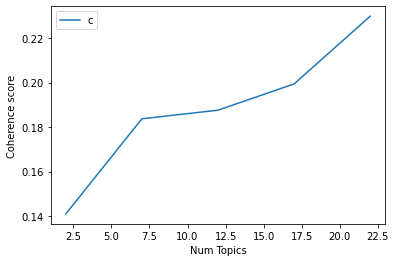

In [23]:
limit=25; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
lda_model_opt = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=25, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
lda_model_opt.save('lda_opt.pkl')

In [25]:
pprint(lda_model_opt.print_topics())

[(22,
  '0.000*"molehill" + 0.000*"baldness" + 0.000*"bokehmovie" + 0.000*"narf" + '
  '0.000*"muck" + 0.000*"aqqqqqq" + 0.000*"parodic" + 0.000*"dichotomous" + '
  '0.000*"weintraub" + 0.000*"rowlson"'),
 (10,
  '0.197*"meet" + 0.081*"think" + 0.076*"boy" + 0.076*"water" + 0.064*"super" '
  '+ 0.052*"sea" + 0.038*"finding" + 0.028*"crafted" + 0.025*"deep" + '
  '0.000*"theatre"'),
 (13,
  '0.309*"comedy" + 0.222*"school" + 0.147*"high" + 0.121*"put" + '
  '0.000*"theatre" + 0.000*"musical" + 0.000*"student" + 0.000*"production" + '
  '0.000*"artist" + 0.000*"theater"'),
 (24,
  '0.515*"play" + 0.199*"space" + 0.140*"free" + 0.011*"manage" + '
  '0.011*"ground" + 0.009*"fighting" + 0.004*"chronicle" + 0.004*"puzzle" + '
  '0.000*"theatre" + 0.000*"artist"'),
 (21,
  '0.136*"man" + 0.118*"run" + 0.115*"night" + 0.099*"around" + 0.066*"hope" + '
  '0.060*"party" + 0.042*"college" + 0.034*"virtual" + 0.033*"land" + '
  '0.030*"brought"'),
 (20,
  '0.229*"creating" + 0.155*"like" + 0.153*"

## LSTM

In [1]:
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.word2vec import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                                                 binary=True, limit=500000)
import pandas as pd
import numpy as np
df = pd.read_csv("df_text_eng.csv")
df['state'] = df['state'].map({"failed": 0, "successful": 1})
df.fillna('', inplace=True)

In [2]:
def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample)
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(word_vectors[token])
            except KeyError:
                pass
        vectorized_data.append(sample_vecs)
    return vectorized_data

In [3]:
def pad_trunc(data, maxlen):
    new_data = []
    
    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)
        
    for sample in data:
        if len(sample) > maxlen:
            temp = sample[:maxlen]
        elif len(sample) < maxlen:
            temp = sample
            addition_elems = maxlen - len(sample)
            for _ in range(addition_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

In [4]:
df.shape

(215513, 3)

In [5]:
X_train, y_train, X_test, y_test = df['blurb'][:50000], df.state[:50000], \
                                   df['blurb'][50000:70000], df.state[500000:70000]

vectorized_train = tokenize_and_vectorize(X_train)
vectorized_test = tokenize_and_vectorize(X_test)

In [6]:
X_train

0        Using their own character, users go on educati...
1        MicroFly is a quadcopter packed with WiFi, 6 s...
2        A small indie press, run as a collective for a...
3        Zylor is a new baby cosplayer! Back this kicks...
4        Hatoful Boyfriend meet Skeletons! A comedy Dat...
                               ...                        
49995           This is inspirational for little children.
49996    This is a sequential art experiment: a comic s...
49997    Young Lizzie doesn't want to wait until she "g...
49998    there is so much beauty in the world around us...
49999    In the minds of every child there is some magi...
Name: blurb, Length: 50000, dtype: object

In [7]:
maxlen = 150
batch_size = 32
embedding_dims = 300
epochs = 30

import numpy as np
x_train = pad_trunc(vectorized_train, maxlen)
x_test = pad_trunc(vectorized_test, maxlen)

x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))

y_train = np.array(y_train)
x_test = np.array(y_test)

In [8]:
maxlen = 150
batch_size = 32
embedding_dims = 300
epochs = 30

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
num_neurons = 80
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, embedding_dims)))
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 80)           121920    
_________________________________________________________________
dropout (Dropout)            (None, 150, 80)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12001     
Total params: 133,921
Trainable params: 133,921
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_test, y_test))

Epoch 1/30
1563/1563 [==============================] - 189s 109ms/step - loss: 0.5281 - accuracy: 0.7412
Epoch 2/30
1563/1563 [==============================] - 167s 107ms/step - loss: 0.4113 - accuracy: 0.8037
Epoch 3/30
1563/1563 [==============================] - 169s 108ms/step - loss: 0.3772 - accuracy: 0.8228
Epoch 4/30
1563/1563 [==============================] - 168s 108ms/step - loss: 0.3491 - accuracy: 0.8394
Epoch 5/30
1563/1563 [==============================] - 165s 106ms/step - loss: 0.3233 - accuracy: 0.8523
Epoch 6/30
1563/1563 [==============================] - 168s 107ms/step - loss: 0.2971 - accuracy: 0.8666
Epoch 7/30
1563/1563 [==============================] - 166s 106ms/step - loss: 0.2788 - accuracy: 0.8746
Epoch 8/30
1563/1563 [==============================] - 169s 108ms/step - loss: 0.2428 - accuracy: 0.8929
Epoch 9/30
1563/1563 [==============================] - 169s 108ms/step - loss: 0.2227 - accuracy: 0.9037
Epoch 10/30
1563/1563 [=======================

In [10]:
model_structure = model.to_json()
with open("lstm_first.json", "w") as json_file:
    json_file.write(model_structure)
model.save_weights("lstm_weights1.h5")